This is the code that implements the 3-flavour (including x and x-bar) using an x--neutrino coefficient as done in Sajad's 2nd paper

We check for Ge, Gx and Gex crossings

In [1]:
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import fsolve
import random

import warnings
warnings.filterwarnings('ignore')  # Comment this to turn on warnings

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

random.seed(10)

In [2]:
import sklearn
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, scale
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit

from sklearn.tree import DecisionTreeClassifier

In [3]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Producing the data using parametric angular distributions 


We here train/test our ML algorithms by
 using parametric neutrino angular distributions. The justifications for this choice are clearly explained in the paper (Sec. II. A).
We use two parametric neutrino angular distributions.
The first one is the maximum entropy distribution
defined as, 

\begin{equation}
f^{\rm{max-ent}}_\nu(\mu) = \frac{1}{ \exp[\eta - a\mu]},
\end{equation}

where 

\begin{equation}
 f_{\nu}(\mu) =  \int_0^\infty \int_0^{2\pi} \frac{E_\nu^2 \mathrm{d} E_\nu \mathrm{d} \phi_\nu}{(2\pi)^3} 
        f_{\nu}(\mathbf{p}).
\end{equation}

Another angular distribution considered here is  the Gaussian distribution defined as,

\begin{equation}
f^{\rm{Gauss}}_\nu(\mu) = A\exp[-\frac{(1-\mu)^2}{a}].
\end{equation}

Note that both of these distributions have parameters which determine the overall neutrino number density, namely
$\eta$ and $A$, and the other parameter  determining the shape of the distribution, i.e., $a$.


In this study, we are interested in the following integrated quantities:

\begin{equation}
\alpha = I^{\bar\nu_e}_0/I^{\nu_e}_0,\  F_{\nu_e} = I^{\nu_e}_1/I^{\nu_e}_0,\ \mathrm{and}\ F_{\bar\nu_e} = I^{\bar\nu_e}_1/I^{\bar\nu_e}_0,
\end{equation}

which are related to the neutrino angular distributions as,

 \begin{equation}
I_n = \int_{-1}^{1} \mathrm{d}\mu\ \mu^n\ \int_0^\infty \int_0^{2\pi} \frac{E_\nu^2 \mathrm{d} E_\nu \mathrm{d} \phi_\nu}{(2\pi)^3} \
        f_{\nu}(\mathbf{p}).
\end{equation}



<br><br>

In the following cell, we develop a parent class called "**AngDist**". This class contains some general methods which perform a range of calculations for the neutrino angular distributions of any type. We have also developed two child classes, namely "*MaxentDist*" and "*GaussianDist*", which represent the maximum entropy and Gaussian angular distributions. In order to *generalize* our distributions, one can easily define the angular distribution (child) class of one's  own. 


In [4]:
class AngDist:
    """ 
    This class is the parent class of the neutrino angular distributions.
    
    ...
    
    Attributes
    ----------
    dist_type : str
        the angular distribution type (currently 'Gaussian' and 'max_ent' are included)
    args, kwargs : float
        the parameters of the angular distributions
        
    Methods
    -------
    params_setter(I_0, flux_factor):
        finds and sets the parameters of the angular distributions, given the values of the neutrino number 
        density, I0, and the flux_factor, using the internal method _params_finder(I_0, flux_factor).
    _params_finder(I_0, flux_factor):
        internal method which helps the 'params_setter' method
    check_solver():
        makes sure that the 'fsolve' has worked well enough (in the 'params_setter' method).
    _help_shape_solver(x):
        internal method which helps _params_finder solver
    _help_norm_solver(self, shape_factor, x):
        internal method which helps _params_finder solver   
    check_XLNcrossing(dist_nue, dist_nueb, dist_nux=None, dist_nuxb=None):
        checks if there is a crossing in the ELN angular distribution. Note that crossings
        are considered only if they are wider than 0.01.
    """
    
    def __init__(self, dist_type, *args, **kwargs):
        self.dist_type = dist_type
        self.args = args
        self.kwargs = kwargs
        
    def params_setter(self, I_0, flux_factor_val):
        self.args = self._params_finder(I_0, flux_factor_val)
                 
    def _params_finder(self, I_0, flux_factor_val):
        shape_factor = fsolve(lambda x: self._help_shape_solver(x) - flux_factor_val, .1)[0] # The first argument of flux_factor is arbitrary
        normalization_factor = fsolve(lambda x: self._help_norm_solver(shape_factor, x) - I_0, .1)[0]
        return normalization_factor, shape_factor

    def _help_shape_solver(self, x):
        self.args = 1., x # 1. is arbitrary here
        return self.flux_factor()

    def _help_norm_solver(self, shape_factor, x):
        self.args = x, shape_factor 
        return self.I0()
    
         
    def check_solver(self):
        _I0_ini, _F_ini = self.I0(), self.flux_factor()
        self.params_setter(_I0_ini, _F_ini)
        _I0_fin, _F_fin = self.I0(), self.flux_factor()
        difference = np.linalg.norm(np.array([_I0_fin - _I0_ini, _F_fin - _F_ini]))
        r = False
        if difference<1.e-2: r = True
        return r
 
    
    @staticmethod
    def check_crossing(dist_nue, dist_nueb, dist_nux=None, dist_nuxb=None):
        x = np.arange(-1.,1.01,.01)   # Only crossings > 0.01 are considered.
        if (not dist_nux) or (not dist_nuxb):                     
            T = np.sign(dist_nue.I0() - dist_nueb.I0()) * (dist_nue.angular_distribution(x) - dist_nueb.angular_distribution(x))
        else:
            T = np.sign(dist_nue.I0() - dist_nux.I0() - dist_nueb.I0() + dist_nuxb.I0()) * ( dist_nue.angular_distribution(x) - dist_nueb.angular_distribution(x) - dist_nux.angular_distribution(x) + dist_nuxb.angular_distribution(x) )     
        r, x_c = False, None        # x_c is the crossing angle
        if (T<0).any():
            r = True
            crossing_ind = np.where(np.diff(np.sign(T)))[0]
            x_c = x[crossing_ind]
        return r, x_c
               
class MaxentDist(AngDist):
    """ 
    The maximum entropy neutrino angular distributions with the shape 'f_nu(mu) = 1./exp(eta-a*mu)'.
    
    ...
    
    Attributes
    ----------
    args : eta, a
        
    Methods
    -------
    angular_distribution(self, mu):
        the angular distribution as a function of mu = cos\theta
    I0(self, *args):
        the total neutrino number density, i.e., I0 = int_{-1}^{+1} f_nu(mu) d_mu 
    flux_factor(self, *args):
        the neutrino flux factor = I1/I0, where I1 = int_{-1}^{+1} mu*f_nu(mu) d_mu 
    """
    
    # Note that the second argument represents the shape (for generalization)
    def __init__(self, eta=1, a=1):
        super().__init__('max_ent', eta, a)
            
    def angular_distribution(self, mu):
        eta , a = self.args
        return np.exp(-eta+a*mu)
        
    
    def I0(self):
        eta , a = self.args
        return 2*np.exp(-eta)*np.sinh(a)/a
      
    def flux_factor(self):
        eta , a = self.args
        return np.cosh(a)/np.sinh(a) - 1./a
        
class GaussianDist(AngDist):
    """ 
    The Gaussian neutrino angular distributions with the shape 'f_nu(mu) = A*exp( -(1-mu)**2/a )'.
    
    ...
    
    Attributes
    ----------
    args : A, a
        
    Methods
    -------
    angular_distribution(self, mu):
        the angular distribution as a function of mu
    I0(self, *args):
        the total neutrino number density, i.e., I0 = int_{-1}^{+1} f_nu(mu) d_mu 
    flux_factor(self, *args):
        the neutrino flux factor = I1/I0, where I1 = int_{-1}^{+1} mu*f_nu(mu) d_mu 
    """
    
    # Note that the second argument represents the shape (for generalization)
    def __init__(self, A=1, a=1):
        super().__init__('Gaussian', A, a)
      
    def angular_distribution(self, mu):
        A , a = self.args
        return A*np.exp( -(1-mu)**2/a ) 
     
    
    def I0(self):
        A , a = self.args
        return A*0.5* np.sqrt(np.pi) * np.sqrt(a) * special.erf(2/np.sqrt(a))
    
    # See the explanation above I0(self, *args). 
    def flux_factor(self):
            A , a = self.args
            I0_ = 0.5* np.sqrt(np.pi) * np.sqrt(a) * special.erf(2/np.sqrt(a))
            I1_ = I0_ + 0.5*a* ( np.exp(-4/a) - 1 )
            return I1_/I0_

###  Example

Now let's see an example of how one can use these classes to generate one's own distributions and assess the ELN crossing. Here, we generate two random distributions and determine the crossing point.

<br><br>


True [0.53]


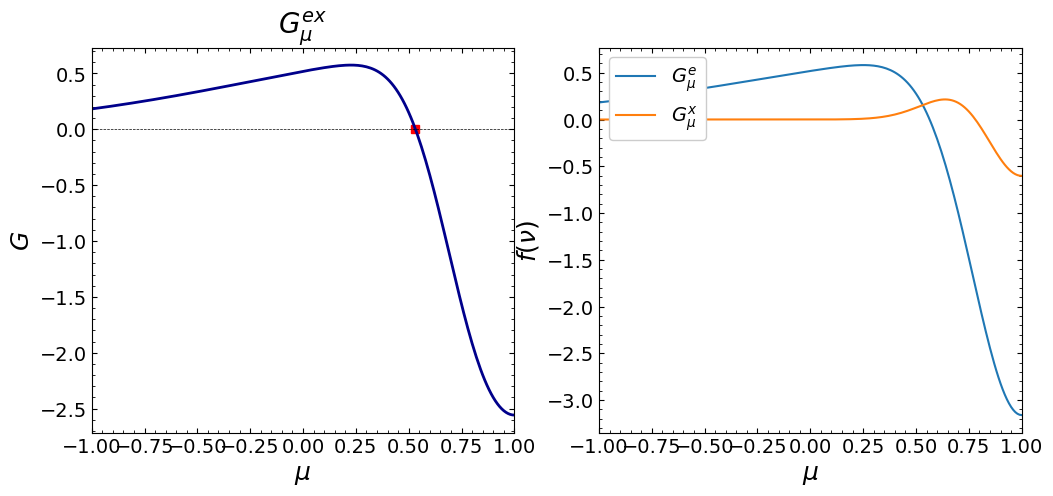

crossing status:  True
crossing point:  [0.53]
Done


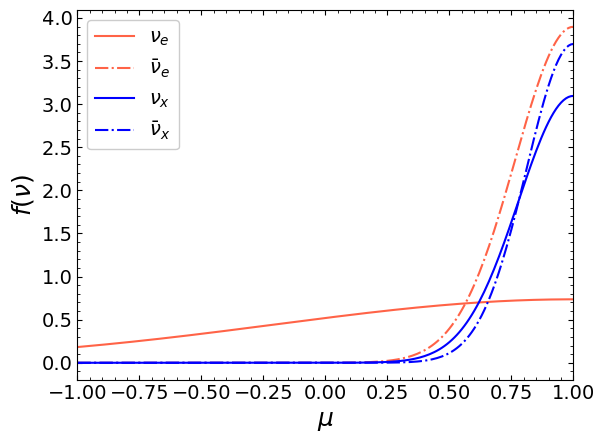

In [5]:
# alpha = n_nueb/n_nue, and F_nue and F_nueb are the flux factors of nu_e and nu_eb
# ----- MY WAY -----
alpha_e, alpha_x = 2*random.random(), 2*random.random()
alpha_xb = alpha_x * (.85 + .3*random.random())

F_nue, F_nueb, F_nux = random.random(), random.random(), random.random()
F_nuxb = F_nux * (.9 + .2*random.random())

# ----- SAJAD WAY -----
# nux_coef = np.random.uniform(-0.4,0.4)  # nux_coef determines the difference between nu_x and nu_xb
# F_nux = random.uniform(0., 1.)
# F_nuxb = min(1, F_nux * (1 + nux_coef)) # nu_xb can be different from nu_x by nux_coef
# F_nueb = random.uniform(0.6*min(F_nux, F_nuxb), min(F_nux, F_nuxb)) # F_nueb is smaller than F_nux(b)
# F_nue = random.uniform(0.6*F_nueb, F_nueb) # F_nue is smaller than F_nueb
# alpha_e = np.random.uniform(0.01,2.5)
# alpha_x = np.random.uniform(0.01,3.)
# alpha_xb = alpha_x + nux_coef*alpha_x # alpha_xb can be different from alpha_x

dis1, dis2, dis3, dis4 = GaussianDist(), GaussianDist(), GaussianDist(), GaussianDist()

dis1.params_setter(1., F_nue)         # 1 is the normalized number density of nu_e 
dis2.params_setter(alpha_e, F_nueb)
dis3.params_setter(alpha_x, F_nux)
dis4.params_setter(alpha_xb, F_nuxb)

cr, mu_c = AngDist.check_crossing(dis1, dis2, dis3, dis4)
x = np.arange(-1.,1.01,.01)   
G = (dis1.angular_distribution(x) - dis2.angular_distribution(x)) - (dis3.angular_distribution(x) - dis4.angular_distribution(x))

print(cr, mu_c)
    
# Ploting
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
if mu_c: plt.plot(mu_c,0,'rs')   
plt.plot(x,G, 'darkblue', lw=2)
plt.plot(x, np.zeros(x.size),'k--', lw=.5)
plt.title(r'$G_\mu^{ex}$', size=20)
plt.xlabel(r'$\mu$',size=18)
plt.ylabel(r'$G$',size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-1,1)

fig.add_subplot(122)
plt.plot(x,dis1.angular_distribution(x) - dis2.angular_distribution(x))
# plt.plot(x,)
plt.plot(x,dis3.angular_distribution(x) - dis4.angular_distribution(x))
# plt.plot(x,)
plt.xlabel(r'$\mu$',size=18)
plt.ylabel(r'$f(\nu)$',size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend((r'$G_\mu^e$ ',r'$G_\mu^x$'), loc = 'upper left', fontsize=14, fancybox=True, framealpha=1.)
plt.xlim(-1,1)

plt.show()

plt.plot(x, dis1.angular_distribution(x), color = 'tomato')
plt.plot(x, dis2.angular_distribution(x), color = 'tomato', linestyle = '-.')
plt.plot(x, dis3.angular_distribution(x), color = 'blue')
plt.plot(x, dis4.angular_distribution(x), color = 'blue', linestyle = '-.')
plt.xlabel(r'$\mu$',size=18)
plt.ylabel(r'$f(\nu)$',size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend((r'$\nu_e$', r'$\bar\nu_e$ ',r'$\nu_x$', r'$\bar\nu_x$'), loc = 'upper left', fontsize=14, fancybox=True, framealpha=1.)
plt.xlim(-1,1)
print('crossing status: ', cr)
print('crossing point: ',  mu_c)
print("Done")
plt.show()

## Producing the datasets
In the following cell, we produce two datasets using the Gaussian and maximum entropy angular distributions defined above.

<br>

In [6]:
def make_data(distribution_class, num_pnts):
    """ 
    This function generates a dataset containing a number of nu_e and nu_eb angular distributions, and 
    whether there exists a crossing for them.
        
    Parameters
    ----------
    distribution_class: python class
        the type of the neutrino angular distribution, currently MaxentDist & GaussianDist
    alpha_array : numpy 1D array
        includes the values of alpha = n_nueb/n_nue for which the ELN angular distribution is investigated
    num_pnts: int
        the number of random points in the (F_nue, F_nueb) parameter space for each alpha
        
    Returns
    -------
    numpy array 
        of the size (alpha_array.size, num_pnts, 8) where 8 refers to [alpha, F_nue, F_nueb, ELN_crossing, 
        prm_nue1, prm_nue2, prm_nueb1, prm_nueb2] with prm_nue and prm_nueb being the parameters of nu_e and 
        nu_eb distributions
    """
    
    data = np.zeros((num_pnts, 8))
    n = 0
    while n < num_pnts:
        # ----- MY WAY -----
        # alpha_e, alpha_x = 2*random.random(), 2*random.random()
        # alpha_xb = alpha_x * (.85 + .3*random.random())
        # F_nue, F_nueb, F_nux = random.random(), random.random(), random.random()
        # F_nuxb = F_nux * (.9 + .2*random.random())
        
        # ----- SAJAD WAY -----
        nux_coef = np.random.uniform(-0.4,0.4)  # nux_coef determines the difference between nu_x and nu_xb
        F_nux = random.uniform(0., 1.)
        F_nuxb = min(1, F_nux * (1 + nux_coef)) # nu_xb can be different from nu_x by nux_coef
        F_nueb = random.uniform(0.6*min(F_nux, F_nuxb), min(F_nux, F_nuxb)) # F_nueb is smaller than F_nux(b)
        F_nue = random.uniform(0.6*F_nueb, F_nueb) # F_nue is smaller than F_nueb
        alpha_e = np.random.uniform(0.01,2.5)
        alpha_x = np.random.uniform(0.01,3.)
        alpha_xb = alpha_x + nux_coef*alpha_x # alpha_xb can be different from alpha_x

        # ----- CROSSING CALCULATION -----
        dis1, dis2, dis3, dis4 = distribution_class(), distribution_class(), distribution_class(), distribution_class()
        
        dis1.params_setter(1., F_nue)         # 1 is the normalized number density of nu_e 
        dis2.params_setter(alpha_e, F_nueb)
        dis3.params_setter(alpha_x, F_nux)
        dis4.params_setter(alpha_xb, F_nuxb)

        # We only count the points if the solver has done its job correctly
        if dis1.check_solver() and dis2.check_solver() and dis3.check_solver() and dis4.check_solver(): 
            data[n, :7] = alpha_e, alpha_x, alpha_xb, F_nue, F_nueb, F_nux, F_nuxb

                        #  (alpha_e - alpha_xb)/(1-alpha_x  + 1e-8)
            
            crossing_class = (int)(0)
            if AngDist.check_crossing(dis1, dis2, dis3, dis4)[0]: crossing_class = 1    # If ELN crossing is absent, it is 0
            # data[alp, n, 6:] = *dis1.args, *dis2.args, *dis3.args, *dis4.args    # The parameters, e.g, a & eta
            if AngDist.check_crossing(dis1, dis2)[0]: crossing_class = crossing_class | 2
            if AngDist.check_crossing(dis3, dis4)[0]: crossing_class = crossing_class | 4

            data[n, -1] = crossing_class
            n += 1
        print(f'\r Done: {n} | {num_pnts}', end='')
    print('\n')
    return data 

In [7]:
# Number of data points
NUM_PNTS = 25000

# # Producing two angular distributions with the dimensions (ALPHA.size, NUM_PNTS, 8)
# # This might take ~2-3 minutes
# data_max_ent = make_data(MaxentDist, NUM_PNTS) 
# data_gaussian= make_data(GaussianDist, NUM_PNTS)

In [8]:
# In case we want to save the dataset to prevent having to constantly generate a new dataset

# data_dir = '../data/all_crossings'
# if not os.path.isdir(data_dir): os.mkdir(data_dir)

# np.save("../data/all_crossings/Gaussian_data_7params_Sajad_way.npy", data_gaussian)
# np.save("../data/all_crossings/Max_entr_data_7params_Sajad_way.npy", data_max_ent)

In [9]:
# In case we want to load the dataset instead of creating it

# Number of data points
# NUM_PNTS = 100000

data_gaussian = np.load("../data/all_crossings/Gaussian_data_7params_my_way_no_type.npy")
data_max_ent = np.load("../data/all_crossings/Max_entr_data_7params_my_way_no_type.npy")
# [data_gaussian.shape, data_max_ent.shape]


In [10]:
def make_subplots(legend=False, x_idx = 3, y_idx = 4, other_points = [.5,.5,.5,.5,.5,.5]):
    """ 
    This function makes a scatter plot of the zones for which ELN crossing exist, in (F_nue, F_nueb), given alpha.
        
    """

    legends = [r'$\alpha_e$', r'$F_{\nu_e}$', r'$F_{\bar\nu_e}$', r'$F_{\nu_x}$', r'$F_{\bar\nu_x}$']
                # , r'$\alpha_x$', r'$\alpha_{xb}$'
    # plt.title(r'$\alpha = $ ' + str(alpha), size=20)
    plt.xlabel(legends[x_idx],size=18)
    plt.ylabel(legends[y_idx],size=18)
    plt.scatter(2, 2, marker='o',color='tomato',s=20, alpha=1); 
    plt.scatter(2, 2, marker='x',color='darkblue',s=30, alpha=1)
    for i in range(0, NUM_PNTS):

        # Making sure the other elements are in the right order
        j = -1

        data_max_plot = True
        data_gauss_plot = True
        for k in range(len(legends)):
            if k != x_idx and k != y_idx:
                j += 1
                if abs(data_max_ent[i,k] - other_points[j]) > 0.5:
                    data_max_plot = False
                
                if abs(data_gaussian[i,k] - other_points[j]) > 0.5:
                    data_gauss_plot = False

        if data_max_plot and data_max_ent[i,-1] == 1:
            plt.scatter(data_max_ent[ i,x_idx], data_max_ent[ i,y_idx], marker='o', rasterized=True, label='',color='tomato',s=10, alpha=1)
        
        if data_gauss_plot and data_gaussian[i,-1] == 1:
            plt.scatter(data_gaussian[ i,x_idx], data_gaussian[ i,y_idx], marker='x', rasterized=True, label='',color='darkblue',s=10, alpha=1)
        
    plt.minorticks_on()
    plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
    plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(-0.0001,1.)
    plt.xlim(-0.0001,1.)
    # plt.legend(("crossings", "no crossings"), loc = 'lower right', fontsize=14, fancybox=True, framealpha=1.)
    if legend: plt.legend(("max-ent","Gaussian"), loc = 'lower right', fontsize=14, fancybox=True, framealpha=1.)

In [11]:
# fig=plt.figure(figsize=(15,11), dpi=140)
# # fig.add_subplot(331); make_subplots(True, 0, 1)
# fig.add_subplot(332); make_subplots(True, 0,2, [.8, .5,.5,.5,.5, .5])
# plt.title("All crossings")
# plt.show()

## Data splitting

In order to train/test the ML algorithms, we split our dataset into training and test sets. Though we do not show it here, we consider anotehr independent set as our development set, to fix the hyper-parameters of the ML algorithms.

<br><br>

In [12]:
data = np.concatenate((data_gaussian, data_max_ent), axis=0)     # combine the two data sets
print(data.shape, data_max_ent.shape)

X = data[:,:-1]
y = data[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

(50000, 8) (25000, 8)


In [13]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components = 3)
 
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
 
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.50037622, 0.24963448, 0.12133223])

# ML algorithms

In this part, we show our results on detecting νELN crossings with the application of ML algorithms. We first focus on Logistic Regression (LR), which turns out to be the most promising ML algorithm to be used in detecting νELN crossings. 

In order to capture the non-linear patterns,  one should first make non-linear transformations and generate new features out of the original three
features in  the problem. *Python sklearn* provides a module which does this, given the polynomial degree of the
nonlinear transformation, which is a hyper-parameter of this algorithm. We have fixed this parameter to be 9 (see Fig.~2 of the paper). 


Note that this might take a few minutes since the LR algorithm converges slowly.

<br><br>

In [14]:
lin_mod = LogisticRegression(max_iter=100000 )

graph = []

for deg in range(2,3):
    # We first make a polynomial transfomration to use the LR for a nonlinear problem
    poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
    XX_train = poly.fit_transform(X_train); XX_test = poly.fit_transform(X_test)
    # X_train = scale(X_train); XX_test = scale(XX_test)

    lin_mod.fit(XX_train,y_train)
    prediction = lin_mod.predict(XX_test)

    target_names = ['no crossing', 'crossing']
    # target_names = ['no crossing', 'crossing ex', 'crossing e', 'crossing ex, e', "crossing x", "crossing ex, x", "crossing x,e", "crossing ex, e, x"]

    score = sklearn.metrics.classification_report(y_test, prediction, target_names=target_names)
    print(score)

              precision    recall  f1-score   support

 no crossing       0.46      0.07      0.12       956
    crossing       0.91      0.99      0.95      9044

    accuracy                           0.90     10000
   macro avg       0.68      0.53      0.53     10000
weighted avg       0.87      0.90      0.87     10000



## LR classification error

Let's make a plot to see where the LR algorithm fails to predict the right classification for $\alpha$'s in the range (0.7,1.3), which is more relevant regarding CCSNe and NSM's. This provides us with an understanding of where the accuracy is minimum. As one can see, the following plots makes completely sense since this is the region where one has noisy dataset (see the discussion in the paper).

<br><br>

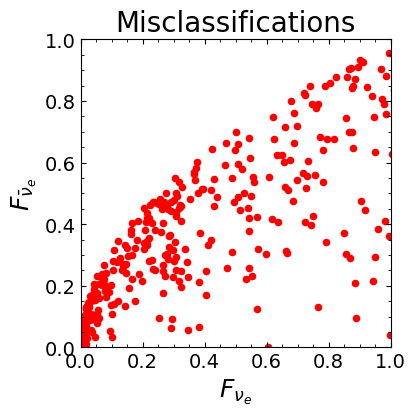

In [15]:
x_axis_idx = 3
y_axis_idx = 4
legends = [r'$\alpha_e$', r'$\alpha_x$', r'$\alpha_{xb}$', r'$F_{\nu_e}$', r'$F_{\bar\nu_e}$', r'$F_{\nu_x}$', r'$F_{\bar\nu_x}$']

fig = plt.figure(figsize=(4,4))
plt.title('Misclassifications', size=20)
plt.xlabel(legends[x_axis_idx],size=18)
plt.ylabel(legends[y_axis_idx],size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.0001,1.)
plt.xlim(-0.0001,1.)

for i in range(prediction.size):
    if abs(prediction[i]-y_test[i])>1.e-3: # and XX_test[i,0]>0.7 and XX_test[i,0]<1.3:
        plt.scatter(XX_test[i,x_axis_idx], XX_test[i,y_axis_idx], marker='o',color='red',s=20, alpha=1); 
plt.show()

In [16]:
# # Saving the coef. of the Logistic Regression classifier and poly.fit_transform
np.save("poly_powers_2_flavor_all_crossings",  poly.powers_)
np.save("lin_mod_intercept_2_flavor_all_crossings", lin_mod.intercept_)
np.save("lin_mod_coef_2_flavor_all_crossings", lin_mod.coef_)

## KNN

Though KNN is perhaps the simplest and most straightforward algorithm in many different respects, its implementation in detecting $\nu$ELN crossings in CCSN and NSM simulations may not be that efficient. This is because at any classification, one needs to load and analyze the whole training dataset, which could be computationally expensive.

We here also show how the results change once one uses cross validation. Obviously, cross validation does not affect the results since the dataset is already generic enough.

<br><br>

In [17]:
# knn = pickle.load(open('../best_models/knn_model_ex_crossings_best_pickle', 'rb'))

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)

prediction = knn.predict(X_test)

target_names = ['no crossing', 'crossing']
# target_names = ['no crossing', 'crossing ex', 'crossing e', 'crossing ex, e', "crossing x", "crossing ex, x", "crossing x,e", "crossing ex, e, x"]

print(sklearn.metrics.classification_report(y_test, prediction, target_names=target_names))

# Here we comment on the idea of cross validation. 
scores = cross_val_score(knn, X, y, cv=5)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
print("cross validation scores, with n_splits=5:")
print(cross_val_score(knn, X_test, y_test, cv=cv))


              precision    recall  f1-score   support

 no crossing       0.29      0.15      0.20       956
    crossing       0.91      0.96      0.94      9044

    accuracy                           0.88     10000
   macro avg       0.60      0.56      0.57     10000
weighted avg       0.86      0.88      0.87     10000

cross validation scores, with n_splits=5:
[0.8755 0.8885 0.8885 0.906  0.8905]


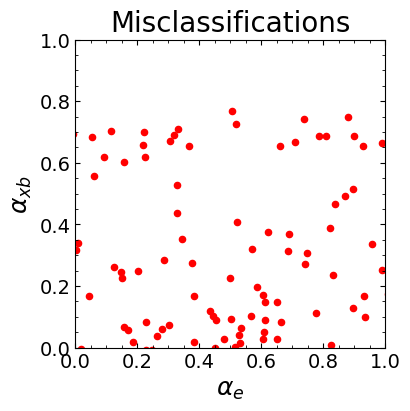

In [18]:
x_axis_idx = 0
y_axis_idx = 2
legends = [r'$\alpha_e$', r'$\alpha_x$', r'$\alpha_{xb}$', r'$F_{\nu_e}$', r'$F_{\bar\nu_e}$', r'$F_{\nu_x}$', r'$F_{\bar\nu_x}$']

fig = plt.figure(figsize=(4,4))
plt.title('Misclassifications', size=20)
plt.xlabel(legends[x_axis_idx],size=18)
plt.ylabel(legends[y_axis_idx],size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.0001,1.)
plt.xlim(-0.0001,1.)

for i in range(prediction.size):
    if abs(prediction[i]-y_test[i])>1.e-3 :
        plt.scatter(X_test[i,x_axis_idx], X_test[i,y_axis_idx], marker='o',color='red',s=20, alpha=1); 
plt.show()

## The performance of SVM \& Decision Tree Classifier


In [19]:
SVM = sklearn.svm.SVC(kernel='rbf', gamma=100.01, degree = 4)
SVM.fit(X_train,y_train)

prediction = SVM.predict(X_test)

target_names = ['no crossing', 'crossing']
# target_names = ['no crossing', 'crossing ex', 'crossing e', 'crossing ex, e', "crossing x", "crossing ex, x", "crossing x,e", "crossing ex, e, x"]

print(sklearn.metrics.classification_report(y_test, prediction, target_names=target_names))

In [20]:
# Saving model


# data_dir = '../best_models/all_corossings'
# if not os.path.isdir(data_dir): os.mkdir(data_dir)

# pickle.dump(mod, open(data_dir + '/svm_model_best_pickle', 'wb'))

# # load retrieve

# mod = pickle.load(open(data_dir + '/svm_model_best_pickle', 'rb'))

In [21]:
x_axis_idx = 0
y_axis_idx = 2
legends = [r'$\alpha_e$', r'$\alpha_x$', r'$\alpha_{xb}$', r'$F_{\nu_e}$', r'$F_{\bar\nu_e}$', r'$F_{\nu_x}$', r'$F_{\bar\nu_x}$']

fig = plt.figure(figsize=(4,4))
plt.title('Misclassifications', size=20)
plt.xlabel(legends[x_axis_idx],size=18)
plt.ylabel(legends[y_axis_idx],size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.0001,1.)
plt.xlim(-0.0001,1.)

for i in range(prediction.size):
    if (prediction[i]-y_test[i])>1.e-3 and X_test[i,0]>0.7 and X_test[i,0]<1.3:
        plt.scatter(X_test[i,x_axis_idx], X_test[i,y_axis_idx], marker='o',color='red',s=20, alpha=1); 
plt.show()

In [22]:
mod = DecisionTreeClassifier( class_weight={0: 8, 1: 7, 2:6, 3:5, 4:4, 5:3, 6:2, 7:1})
mod.fit(X_train,y_train)

prediction = mod.predict(X_test)

target_names = ['no crossing', 'crossing']

# target_names = ['no crossing', 'crossing ex', 'crossing e', 'crossing ex, e', "crossing x", "crossing ex, x", "crossing x,e", "crossing ex, e, x"]

print(sklearn.metrics.classification_report(y_test, prediction, target_names=target_names))

              precision    recall  f1-score   support

 no crossing       0.21      0.22      0.22       956
    crossing       0.92      0.91      0.92      9044

    accuracy                           0.85     10000
   macro avg       0.56      0.57      0.57     10000
weighted avg       0.85      0.85      0.85     10000



In [23]:
# Saving model


# data_dir = '../best_models/all_corossings'
# if not os.path.isdir(data_dir): os.mkdir(data_dir)

# pickle.dump(mod, open(data_dir + '/dt_model_best_pickle', 'wb'))

# # load retrieve

# mod = pickle.load(open(data_dir + '/dt_model_best_pickle', 'rb'))

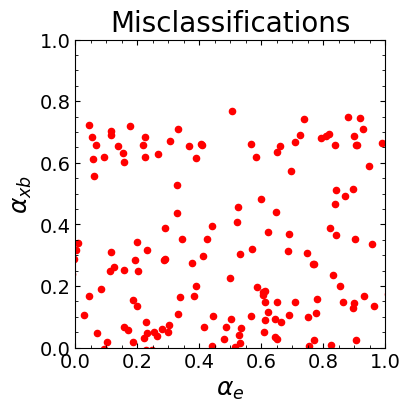

In [24]:
x_axis_idx = 0
y_axis_idx = 2
legends = [r'$\alpha_e$', r'$\alpha_x$', r'$\alpha_{xb}$', r'$F_{\nu_e}$', r'$F_{\bar\nu_e}$', r'$F_{\nu_x}$', r'$F_{\bar\nu_x}$']

fig = plt.figure(figsize=(4,4))
plt.title('Misclassifications', size=20)
plt.xlabel(legends[x_axis_idx],size=18)
plt.ylabel(legends[y_axis_idx],size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.0001,1.)
plt.xlim(-0.0001,1.)

for i in range(prediction.size):
    if abs(prediction[i]-y_test[i])>1.e-3: # and X_test[i,0]>0.7 and X_test[i,0]<1.3:
        plt.scatter(X_test[i,x_axis_idx], X_test[i,y_axis_idx], marker='o',color='red',s=20, alpha=1); 
plt.show()